In [8]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization,concatenate,UpSampling2D,Dropout
from tensorflow.keras.models import Model

In [ ]:
mkdir checkpoints

In [3]:
X = np.load("../input/teeth-segmentation-npy-files/X.npy")
Y = np.load("../input/teeth-segmentation-npy-files/Y.npy")
X.shape, Y.shape

((464, 512, 512, 1), (464, 512, 512, 1))

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, 
                                                    shuffle=True, 
                                                    random_state=42)

In [5]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((371, 512, 512, 1), (93, 512, 512, 1), (371, 512, 512, 1), (93, 512, 512, 1))

In [17]:
def UNET (input_shape=(512,512,1),last_activation='sigmoid'):
    model = Sequential()

    #Encoder
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    #Decoder
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(1, (1, 1), activation='sigmoid', padding='same'))
    
    return model

model = UNET()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 512, 512, 32)      320       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 256, 256, 32)      128       
_________________________________________________________________
dropout_10 (Dropout)         (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 256, 256, 64)      18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 128, 128, 64)     

In [18]:
from keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    return(2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def IOU(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    
    return intersection/union

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred, 1)

def specificity(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return tn / (tn + fp + K.epsilon())

In [19]:
import tensorflow as tf
model_ckt = tf.keras.callbacks.ModelCheckpoint(
    "./checkpoints/",
    monitor='val_accuracy',
    verbose = 1,
    save_best_only=False,
    save_weights_only=True,
    mode='max',
    save_freq='epoch',
)
learningrate_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                           mode = 'max',
                                                           factor = 0.1, 
                                                           patience = 20, 
                                                           verbose = 1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', 
                                                 patience = 20, 
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                  verbose=1)

callbacks_list = [learningrate_scheduler, early_stopping, model_ckt]

In [20]:
import tensorflow as tf
import tensorflow_addons as tfa
model.compile(optimizer =tf.keras.optimizers.Adam(learning_rate = 0.001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy', dice_coef, IOU, specificity,
                         tf.keras.metrics.Recall(name='recall'),
                         tf.keras.metrics.Precision(name='precision')])

history = model.fit(X_train, Y_train,
          validation_data=(X_test, Y_test),
          batch_size=8,
          epochs=200,
          verbose=1,
          callbacks = callbacks_list)

Epoch 1/200
47/47 [==============================] - 9s 150ms/step - loss: 0.4486 - accuracy: 0.8127 - dice_coef: 0.5489 - IOU: 0.3808 - specificity: 0.8720 - recall: 0.8122 - precision: 0.7109 - val_loss: 0.4901 - val_accuracy: 0.7531 - val_dice_coef: 0.2794 - val_IOU: 0.1625 - val_specificity: 0.9997 - val_recall: 0.0063 - val_precision: 0.9009

Epoch 00001: saving model to ./checkpoints/
Epoch 2/200
47/47 [==============================] - 6s 121ms/step - loss: 0.3052 - accuracy: 0.8603 - dice_coef: 0.6421 - IOU: 0.4734 - specificity: 0.9243 - recall: 0.8460 - precision: 0.8391 - val_loss: 0.6131 - val_accuracy: 0.7523 - val_dice_coef: 0.1123 - val_IOU: 0.0595 - val_specificity: 1.0000 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00

Epoch 00002: saving model to ./checkpoints/
Epoch 3/200
47/47 [==============================] - 6s 120ms/step - loss: 0.2497 - accuracy: 0.8723 - dice_coef: 0.6929 - IOU: 0.5306 - specificity: 0.9383 - recall: 0.8505 - precision: 0.8753 - val_loss

In [21]:
hist_df = pd.DataFrame(history.history)
hist_df.to_csv("model_history.csv")

In [22]:
hist_df

,loss,accuracy,dice_coef,IOU,specificity,recall,precision,val_loss,val_accuracy,val_dice_coef,val_IOU,val_specificity,val_recall,val_precision,lr
0,0.448557,0.812703,0.548886,0.380823,0.871976,0.812161,0.710929,0.490138,0.753088,0.279441,0.162489,0.999724,0.006278,0.900874,0.001000
1,0.305187,0.860289,0.642079,0.473374,0.924287,0.846008,0.839083,0.613072,0.752267,0.112299,0.059491,1.000000,0.000000,0.000000,0.001000
2,0.249686,0.872334,0.692857,0.530603,0.938317,0.850548,0.875318,0.669050,0.752267,0.085373,0.044590,1.000000,0.000000,0.000000,0.001000
3,0.217422,0.876913,0.721066,0.564141,0.941744,0.860493,0.886478,0.735310,0.752267,0.062677,0.032352,1.000000,0.000000,0.000000,0.001000
4,0.188789,0.879840,0.737864,0.584767,0.945483,0.860879,0.895284,0.861806,0.752267,0.034884,0.017751,1.000000,0.000000,0.000000,0.001000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,0.037318,0.915785,0.944301,0.894483,0.994846,0.868170,0.996001,0.072414,0.907864,0.924855,0.860320,0.988431,0.854156,0.983056,0.000001
189,0.037304,0.915785,0.944295,0.894472,0.994869,0.867972,0.996038,0.072422,0.907863,0.924858,0.860324,0.988431,0.854139,0.983065,0.000001
190,0.037298,0.915794,0.944261,0.894410,0.994834,0.868337,0.996019,0.072422,0.907861,0.924875,0.860355,0.988401,0.854285,0.983028,0.000001
191,0.037311,0.915791,0.944301,0.894482,0.994854,0.868076,0.996033,0.072427,0.907866,0.924869,0.860344,0.988412,0.854282,0.983054,0.000001


In [25]:
model.save('unet_five.h5')

In [26]:
pred = model.predict(X_test)

In [45]:
from sklearn.metrics import f1_score
import numpy as np

predict_img1=(pred>0.25)*1
y_test1=(Y_test>0.25)*1
f1_score(predict_img1.flatten(), y_test1.flatten(), average='micro')

0.977325685562626

In [27]:
pred.shape

(93, 512, 512, 1)

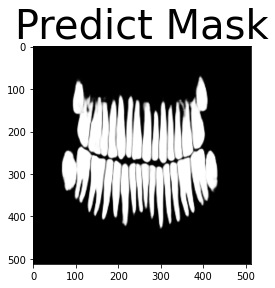

In [40]:
# plt.figure(figsize = (20,10))
plt.title("Predict Mask",fontsize = 40)
plt.imshow(pred[50,:,:,0], cmap='gray')

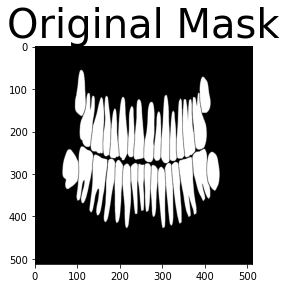

In [41]:
plt.title("Original Mask",fontsize = 40)
plt.imshow(Y_test[50,:,:,0], cmap='gray')